In [ ]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import csv

In [ ]:
#data_path = '/home/gonzalez/Desktop/age_gender/age_gender.csv' # old data
# url = 'https://www.kaggle.com/code/shahraizanwar/age-gender-ethnicity-prediction/data?select=age_gender.csv'

# processing color data from Pierre

In [ ]:
 # new data from Pierre
data_path = '/home/gonzalez/code/jagonzalezj/age_gender/raw_data/new_data.csv' 
data = pd.read_csv(data_path, encoding='utf-8')

lola =[]   
for i in range(len(data['image'])):
    a = data['image'][i].replace('[',',').replace(']',',').replace(',','').split()
    lola.append([int(j) for j in a])
    
data['image']=lola
data.columns=['age', 'gender', 'ethnicity', 'pixels']

data['ethnicity'].unique()[5:]
for items in data['ethnicity'].unique()[5:]:
    data = data.drop(data[data.ethnicity==items].index).copy()

data = data.dropna()
data.reindex()

# Loading data from google cloud to google colab

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
df=pd.read_csv('gdrive/My Drive/age_gender.csv')

# Transforming the pixels data type into a list of float

In [ ]:
# images =[]
# for fotos in range(len(data['pixels'])):
#     X = data['pixels'][fotos].split(" ")
#     X = list(map(int, X))
#     images.append(X)

In [ ]:
# x = np.reshape(images[5000], (48,48))

In [ ]:
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [ ]:
blob = data['pixels'][0].reshape(48,48)

In [ ]:
plt.imshow(blob, cmap='gray');

In [ ]:
#sns.displot(data['ethnicity']),
#sns.displot(data['gender']), 
#sns.displot(data['age']);
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
sns.histplot(ax=axes[0], x=data['age']);
sns.histplot(ax=axes[1], x=data['ethnicity']);
sns.histplot(ax=axes[2], x=data['gender']);

# Working with the age

In [ ]:
# list the number of counts per age
ages = data['age'].unique()
counts = []
for age in ages:
    counts.append(np.count_nonzero(data['age']==age))

In [ ]:
# table with the first 15 most dense samples regarding age
type(ages), type(counts)
s =pd.DataFrame([ages.T, np.array(counts).T],['ages', 'counts'])
s=s.transpose()
more_dense = s.sort_values(by=['counts'], ascending=False)
more_dense.head(15)

In [ ]:
data = data.drop(data[data.age==29].index).copy()
data.reset_index(drop=True)

In [ ]:
sns.histplot(data.age);

The filter of Pierre

In [ ]:
data_clean = data.copy()
data['points_bin'] = pd.qcut(data_clean['age'], q=10)

#view updated DataFrame
print(data)
data['points_bin'].value_counts()

In [ ]:
data

# External image manipulation funtions

In [ ]:
import cv2
import sys, os

In [ ]:
# get image
#locattion = "/home/gonzalez/foto.jpg" # javier
#locattion = "/home/gonzalez/Paul.jpeg" # Paul
#locattion = "/home/gonzalez/Konstantine.jpeg"
locattion = "/home/gonzalez/ping.jpg" # Paul



In [ ]:
#base_dir = os.path.dirname(locattion)
#image = cv2.imread("/home/gonzalez/foto.jpg")
#plt.imshow(image, cmap='gray');
#print(f'==> image resolution {image.shape}')

# from PIL import Image           # this can be used to rotate images
# image = Image.open(locattion)

# (h, w) = image.shape[:2]
# blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
# #blob.shape
# blob.shape

In [ ]:
imagePath=locattion
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(30, 30)
)

print("[INFO] Found {0} Faces.".format(len(faces)))

for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0),1)
    roi_color = image[y:y + h, x:x + w]
    #print("[INFO] Object found. Saving locally.")
    #cv2.imwrite(str(w) + str(h) + '_faces.jpg', roi_color)

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,16))

ax1.imshow(image) # original image

ax2.imshow(roi_color) # recorted original image
roi_color.shape

img = np.mean(roi_color, axis=2) # black and white image
ax3.imshow(img, cmap='gray');

img=img[2:,2:]  # remove red line effect

res_final = cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_LINEAR)
ax4.imshow(res_final, cmap='gray');


In [ ]:
res_final.shape
res_final_ready = np.reshape(res_final, (-1, 48, 48,1))
res_final_ready.shape

In [ ]:
# model.predict(res_final_ready)
# index = np.where(model.predict(res_final_ready)==(model.predict(res_final_ready).max()))
# index[1][0]

In [ ]:
#model = models.load_model('Model48_datafiltered/')
int(model.predict(res_final_ready)[0][0])

#model.predict(res_final_ready)
#index = np.where(model.predict(res_final_ready)==(model.predict(res_final_ready).max()))
#print(f'slot number {index[1][0]}, correspond to range {index[1][0]*step_size-step_size} to {index[1][0]*step_size}')

In [ ]:
# resize image

In [ ]:
# image conver to black and white
#image = cv2.imread(imagePath)
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Function for transforming data numbers into data range classification

In [ ]:
# categorize age per range:
def age_categorize(input_list, age_step=10):
    '''
    Enter the list of age into input_list and the age steps
    with : age_step = 5;  age = 4   =>  1-5
                          age = 12  =>  10-15                        
    '''
    
    cat_age = []
    for age in input_list:
        
        a = float(age)/float(age_step)
        
        if a > 1:
            entero = int(a)
            coma = a-entero
            
            if coma > 0:
                entero = entero+1
            
            max = entero * age_step
            min = max-(age_step-1)     
            #cat_age.append(f'{min} to {max}')   # if the output is in the real intervale
            cat_age.append(int(max/age_step)-1)  # if the output is in categorical int number
        else:
            min = 1
            max = age_step
            #cat_age.append(f'{min} to {max}')    # if the output is in the real intervale   
            cat_age.append(int(max/age_step)-1)   # if the output is in categorical int number

            
    return cat_age

# Here we go with the model

In [ ]:
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split

In [ ]:
# X = data['pixels'].tolist()
# X = np.reshape(X, (-1, 48, 48,1))


X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,3))

y=data['age']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen=ImageDataGenerator(rescale=1/255)
# train_generator_age=train_datagen.flow(
#     X_train ,y_train ,batch_size=32)

# test_datagen=ImageDataGenerator(rescale=1/255)
# test_generator_age=test_datagen.flow(
#     X_test ,y_test ,batch_size=32)

In [ ]:
def initialize_model(numb_int, numb_out):
    
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,numb_int)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
   
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))          

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='relu'))
   
    return model

In [ ]:
model = initialize_model(X.shape[-1], y.shape[-1])
model.summary()

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='mae', patience=6, restore_best_weights=True)

# earlystop=EarlyStopping(patience=6)
# learning_rate_reduction=ReduceLROnPlateau(
#     monitor='val_acc',
#     patience= 3,
#     verbose=1,
# )
# callbacks = [earlystop, learning_rate_reduction]

In [ ]:
X_train.shape

In [ ]:
# history_age = model.fit(
#     train_generator_age, 
#     epochs= 60,
#     validation_data= test_generator_age,
#     callbacks= callbacks)

In [ ]:
#history = model.fit(X_train, y_train, epochs=40, callbacks=[es])

In [ ]:
history = model.fit(X, y, validation_split=0.3, epochs=40, callbacks=[es], batch_size=32)

In [ ]:
#history.__dict__

In [ ]:
plt.plot(history.history['loss']);
plt.plot(history.history['mae']);

In [ ]:
models.save_model(model, 'Model48_linearColor')
#model = models.load_model('Model48')

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
n=142
plt.imshow(X[n] );
data.iloc[n]

In [ ]:
#out= model.predict(X_test)
try_inp = np.expand_dims(X[n], axis=0)
model.predict(try_inp)[0,0]

In [ ]:
np.shape(X[0])

# MODEL USING DATA BUCKET

In [ ]:
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split

In [ ]:
step_size = 5
input_list = data['age']
cat = age_categorize(input_list, step_size)
#pd.DataFrame(cat, data['age'].values).sample(100)

In [ ]:
# add categorical age clasification to original dataframe
data['class_age']=cat
#data[['age','class_age']].sample(10)

In [ ]:
sns.histplot(data['class_age']);

In [ ]:
### perform one-hot encoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)
ohe.fit(data[['class_age']])
class_age_encoded = ohe.transform(data[['class_age']])

 Using Pierre distribution

In [ ]:
# Pierre distribution
data_clean = data.copy()
data['points_bin'] = pd.qcut(data_clean['age'], q=10)

#view updated DataFrame
print(data)
data['points_bin'].value_counts()

In [ ]:
# perform one-hot encoder to the Pierre distribution
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)
ohe.fit(data[['points_bin']])
class_age_encoded = ohe.transform(data[['points_bin']])

In [ ]:
for elements in range(class_age_encoded.shape[1]):
    data[str(elements)]=class_age_encoded[:,elements]

In [ ]:
y=data.drop(columns=['age','ethnicity','gender', 'pixels', 'points_bin'])

Finished Pierre encoding

In [ ]:
#y=data.drop(columns=['age','ethnicity','gender', 'pixels', 'class_age'])
#y=data.drop(columns=['age','ethnicity','gender', 'img_name', 'pixels', 'points_bin'])

In [ ]:
X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,3))

y = class_age_encoded

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
def initialize_model_catgorical(numb_int, numb_out):
        
    model = Sequential()
    model.add(layers.Conv2D(32,(3,3), padding='same',activation='relu',input_shape=(48,48,numb_int)))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(32,(3,3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(64,(3,3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
   
    #model.add(layers.Flatten())
    #model.add(layers.Dense(128,activation='relu'))

    model.add(layers.Dense(numb_out, activation='softmax'))   
    return model

In [ ]:
#model = initialize_model_catgorical()
model = initialize_model_catgorical(X.shape[-1], y.shape[-1])

model.summary()

In [ ]:
model.compile(optimizer='adam' ,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='accuracy', patience=6, restore_best_weights=True)

In [ ]:
history_cat = model.fit(X_train,y_train, validation_split=0.3, epochs=50, callbacks=[es])

In [ ]:
#history_cat = model.fit(X, y, validation_split=0.3, epochs=40, callbacks=[es], batch_size=32)  # the best

In [ ]:
models.save_model(model, 'Model48_categorical_ColorData')

In [ ]:
plt.plot(history_cat.history['val_accuracy']);
plt.plot(history_cat.history['accuracy']);

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
n=244
plt.imshow(X[n], cmap='gray');
#np.where(y.iloc[n]==1)[0]
print(f"real age is {data.iloc[n]}")

In [ ]:
try_inp = np.expand_dims(X[n], axis=0)
model.predict(try_inp).max()
index = np.where(model.predict(try_inp)==(model.predict(try_inp).max()))
index[1][0]

In [ ]:
model.predict(try_inp)

In [ ]:
try_inp = np.expand_dims(X[n], axis=0)
model.predict(try_inp).max()
index = np.where(model.predict(try_inp)==(model.predict(try_inp).max()))
print(f'slot number {index[1][0]}, correspond to range {index[1][0]*step_size-step_size} to {index[1][0]*step_size}')

# best results using colab with regression on virgen data

In [ ]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import csv

from google.colab import drive 
drive.mount('/content/gdrive')
data=pd.read_csv('gdrive/My Drive/age_gender.csv')

data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

from tensorflow.keras import Sequential, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split

X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,1))

y = data['age']


def initialize_model():
    
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
   
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))          

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='relu'))
   
    return model

model = initialize_model()
model.summary()

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

history = model.fit(X_train, y_train, epochs=100, callbacks=[es])

plt.plot(history.history['loss']);
plt.plot(history.history['mae']);

n=5
out = np.reshape(X_test[n], (48, 48))
plt.imshow(out, cmap='gray');
y_test.iloc[n]

try_inp = np.expand_dims(X_test[n], axis=0)
model.predict(try_inp)[0,0]

# Combination of categorical plus linear for BW images

In [2]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import csv
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split

In [3]:
def initialize_model_regression():
    
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
   
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))          

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='relu'))
   
    return model

In [20]:
def initialize_model_catgorical(numb_int, numb_out):
        
    model = Sequential()
    model.add(layers.Conv2D(32,(3,3), padding='same',activation='relu',input_shape=(48,48,numb_int)))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(32,(3,3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(64,(3,3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
   
    #model.add(layers.Flatten())
    #model.add(layers.Dense(128,activation='relu'))

    model.add(layers.Dense(numb_out, activation='softmax'))   
    return model

In [4]:
data_path = '/home/gonzalez/Desktop/age_gender/age_gender.csv' # old data
data = pd.read_csv(data_path)
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [5]:
# Pierre distribution
data_clean = data.copy()
data['points_bin'] = pd.qcut(data_clean['age'], q=3)

#view updated DataFrame
print(data)
data['points_bin'].value_counts()

       age  ethnicity  gender                        img_name  \
0        1          2       0  20161219203650636.jpg.chip.jpg   
1        1          2       0  20161219222752047.jpg.chip.jpg   
2        1          2       0  20161219222832191.jpg.chip.jpg   
3        1          2       0  20161220144911423.jpg.chip.jpg   
4        1          2       0  20161220144914327.jpg.chip.jpg   
...    ...        ...     ...                             ...   
23700   99          0       1  20170120221920654.jpg.chip.jpg   
23701   99          1       1  20170120134639935.jpg.chip.jpg   
23702   99          2       1  20170110182418864.jpg.chip.jpg   
23703   99          2       1  20170117195405372.jpg.chip.jpg   
23704   99          0       1  20170110182052119.jpg.chip.jpg   

                                                  pixels     points_bin  
0      [129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133...  (0.999, 26.0]  
1      [164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175....  (0.999, 26.0]

(0.999, 26.0]    9834
(37.0, 116.0]    7822
(26.0, 37.0]     6049
Name: points_bin, dtype: int64

In [6]:
# perform one-hot encoder to the Pierre distribution
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)
ohe.fit(data[['points_bin']])
class_age_encoded = ohe.transform(data[['points_bin']])

In [7]:
for elements in range(class_age_encoded.shape[1]):
    data[str(elements)]=class_age_encoded[:,elements]

## categorical fit

In [22]:
X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,1))

y=data.drop(columns=['age','ethnicity','gender', 'pixels', 'points_bin', 'img_name'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [28]:
model_cat = initialize_model_catgorical(X.shape[-1], y.shape[-1])
    
es = EarlyStopping(monitor='accuracy', patience=6, restore_best_weights=True)

model_cat.compile(optimizer='adam' ,loss='categorical_crossentropy',metrics=['accuracy'])

history_cat = model_cat.fit(X_train,y_train, validation_split=0.3, epochs=50, callbacks=[es])

Epoch 1/50
363/363 [==============================] - 18s 48ms/step - loss: 1.8089 - accuracy: 0.5060 - val_loss: 0.9269 - val_accuracy: 0.5655
Epoch 2/50
363/363 [==============================] - 17s 47ms/step - loss: 0.8885 - accuracy: 0.5842 - val_loss: 0.8414 - val_accuracy: 0.6067
Epoch 3/50
363/363 [==============================] - 16s 44ms/step - loss: 0.8124 - accuracy: 0.6213 - val_loss: 0.8390 - val_accuracy: 0.6175
Epoch 4/50
363/363 [==============================] - 16s 44ms/step - loss: 0.7820 - accuracy: 0.6406 - val_loss: 0.8018 - val_accuracy: 0.6209
Epoch 5/50
363/363 [==============================] - 16s 44ms/step - loss: 0.7523 - accuracy: 0.6522 - val_loss: 0.7914 - val_accuracy: 0.6306
Epoch 6/50
363/363 [==============================] - 16s 44ms/step - loss: 0.7177 - accuracy: 0.6666 - val_loss: 0.8440 - val_accuracy: 0.6029
Epoch 7/50
363/363 [==============================] - 16s 44ms/step - loss: 0.6871 - accuracy: 0.6828 - val_loss: 0.8123 - val_accuracy:

In [ ]:
# calling once the categorical branch model

In [29]:
# looping for all linear model
Histories = []

y = data['age']

for i in range(len(data['points_bin'].unique())):


    # slice the dataframe
    lower = data['points_bin'].unique()[i].left
    upper = data['points_bin'].unique()[i].right
    cacho = data.drop(data[data.age<lower].index | data[data.age>=upper].index).copy()
    
    # prepare the data
    X = cacho['pixels'].tolist()
    X = np.reshape(X, (-1, 48, 48,1))

    y=cacho['age']

    # split data set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    
    print(' ')
    print('*****************************************************************************************')
    print(f'STARTING MODEL =======>>>>>> {i} with age range {lower} to {upper} and {X.shape} samples')
    print('*****************************************************************************************')
    print(' ')


    # initialize the model
    model = initialize_model_regression()
        
    # compile the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    
    # early stopping
    es = EarlyStopping(monitor='mae', patience=6, restore_best_weights=True)


    # fit
    history = model.fit(X_train, y_train,  epochs=40, callbacks=[es])
    
    # save model
    Histories.append(history)
    
    models.save_model(model, f'Model_linear_{lower}_{upper}')
    
    # delete variables to save RAM
    del model, X, y, X_train, X_test, y_train, y_test, es, history, cacho
    

/tmp/ipykernel_20848/1538569307.py:12: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  cacho = data.drop(data[data.age<lower].index | data[data.age>=upper].index).copy()


 
*****************************************************************************************
STARTING MODEL =======>>>>>> 0 with age range 0.999 to 26.0 and (7637, 48, 48, 1) samples
*****************************************************************************************
 
Epoch 1/40
168/168 [==============================] - 8s 43ms/step - loss: 268.0694 - mae: 13.5359
Epoch 2/40
168/168 [==============================] - 7s 43ms/step - loss: 265.8198 - mae: 13.4939
Epoch 3/40
168/168 [==============================] - 7s 43ms/step - loss: 265.8198 - mae: 13.4939
Epoch 4/40
168/168 [==============================] - 7s 43ms/step - loss: 265.8198 - mae: 13.4939
Epoch 5/40
168/168 [==============================] - 7s 44ms/step - loss: 265.8198 - mae: 13.4939
Epoch 6/40
168/168 [==============================] - 7s 43ms/step - loss: 265.8198 - mae: 13.4939
Epoch 7/40
168/168 [==============================] - 7s 44ms/step - loss: 265.8198 - mae: 13.4939
Epoch 8/40
168/168 [=============

/tmp/ipykernel_20848/1538569307.py:12: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  cacho = data.drop(data[data.age<lower].index | data[data.age>=upper].index).copy()


Epoch 1/40
178/178 [==============================] - 8s 43ms/step - loss: 437.9167 - mae: 16.1410
Epoch 2/40
178/178 [==============================] - 8s 43ms/step - loss: 345.5443 - mae: 14.7022
Epoch 3/40
178/178 [==============================] - 8s 43ms/step - loss: 317.5146 - mae: 13.9987
Epoch 4/40
178/178 [==============================] - 8s 44ms/step - loss: 304.9361 - mae: 13.7118
Epoch 5/40
178/178 [==============================] - 8s 46ms/step - loss: 281.1828 - mae: 13.0984
Epoch 6/40
178/178 [==============================] - 8s 46ms/step - loss: 277.7785 - mae: 13.0717
Epoch 7/40
178/178 [==============================] - 8s 45ms/step - loss: 262.0753 - mae: 12.6024
Epoch 8/40
178/178 [==============================] - 8s 45ms/step - loss: 233.8088 - mae: 11.9434
Epoch 9/40
178/178 [==============================] - 9s 48ms/step - loss: 241.8948 - mae: 12.2023
Epoch 10/40
178/178 [==============================] - 9s 48ms/step - loss: 232.9355 - mae: 11.9309
Epoch 11/

/tmp/ipykernel_20848/1538569307.py:12: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  cacho = data.drop(data[data.age<lower].index | data[data.age>=upper].index).copy()


Epoch 1/40
174/174 [==============================] - 9s 47ms/step - loss: 104.5834 - mae: 7.6702
Epoch 2/40
174/174 [==============================] - 9s 50ms/step - loss: 59.3100 - mae: 6.2168
Epoch 3/40
174/174 [==============================] - 8s 46ms/step - loss: 53.4744 - mae: 5.8902
Epoch 4/40
174/174 [==============================] - 8s 45ms/step - loss: 52.4514 - mae: 5.7702
Epoch 5/40
174/174 [==============================] - 8s 45ms/step - loss: 48.8493 - mae: 5.5649
Epoch 6/40
174/174 [==============================] - 9s 50ms/step - loss: 45.5269 - mae: 5.3647
Epoch 7/40
174/174 [==============================] - 8s 45ms/step - loss: 43.3632 - mae: 5.2801
Epoch 8/40
174/174 [==============================] - 9s 49ms/step - loss: 45.2526 - mae: 5.3902
Epoch 9/40
174/174 [==============================] - 9s 54ms/step - loss: 42.7250 - mae: 5.2159
Epoch 10/40
174/174 [==============================] - 8s 47ms/step - loss: 40.0126 - mae: 5.0734
Epoch 11/40
174/174 [=======

## Evaluation test categorical

In [33]:
X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,1))


real age is age                                                          66
ethnicity                                                     0
gender                                                        1
img_name                         20170110140814578.jpg.chip.jpg
pixels        [117.0, 102.0, 106.0, 84.0, 102.0, 94.0, 99.0,...
points_bin                                        (37.0, 116.0]
0                                                           0.0
1                                                           0.0
2                                                           1.0
Name: 21527, dtype: object


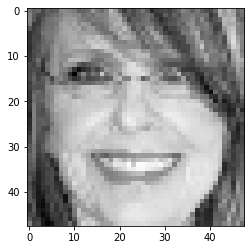

In [71]:
n=21527
plt.imshow(X[n], cmap='gray');
#np.where(y.iloc[n]==1)[0]
print(f"real age is {data.iloc[n]}")

In [68]:
try_inp = np.expand_dims(X[n], axis=0)
model_cat.predict(try_inp).max()
#index = np.where(model_cat.predict(try_inp)==(model_cat.predict(try_inp).max()))
#print(f'slot number {index[1][0]}, correspond to range {index[1][0]*step_size-step_size} to {index[1][0]*step_size}')

0.99915373

In [72]:
model_cat.predict(try_inp)

array([[2.7270298e-04, 5.7354954e-04, 9.9915373e-01]], dtype=float32)

In [73]:
try_inp = np.expand_dims(X[n], axis=0)
model_cat.predict(try_inp).max()
index = np.where(model_cat.predict(try_inp)==(model_cat.predict(try_inp).max()))
index[1][0]

2

## Evaluation test regresional

In [40]:
! ls

age_gender.csv:Zone.Identifier	Model48_datafiltered
images				Model48_linearColor
Javier_age.ipynb		Model_linear_0.999_26.0
Model48				Model_linear_26.0_37.0
Model48_categorical5		Model_linear_37.0_116.0
Model48_categorical_ColorData	Paul_Gender.ipynb
Model48_categorical_pierre	Pierre-Ethnicity.ipynb


In [75]:
# load corresponding regresional model
predict_model = models.load_model('Model_linear_37.0_116.0')

In [76]:
# predict regresional
predict_model.predict(try_inp)

array([[48.85167]], dtype=float32)